In [3]:
import spatialdata as sd

sdata = sd.read_zarr("/gpfs/commons/home/svaidyanathan/othervscode/istarc/data/mouse_brain_visium_hd.sdata.zarr")

print(sdata)

SpatialData object, with associated Zarr store: /gpfs/commons/home/svaidyanathan/othervscode/istarc/data/mouse_brain_visium_hd.sdata.zarr
├── Images
│     ├── 'Visium_Adult_Mouse_Brain_hires_image': DataArray[cyx] (3, 2000, 1921)
│     └── 'Visium_Adult_Mouse_Brain_lowres_image': DataArray[cyx] (3, 600, 576)
├── Shapes
│     └── 'Visium_Adult_Mouse_Brain': GeoDataFrame shape: (2702, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (2702, 32285)
with coordinate systems:
    ▸ 'Visium_Adult_Mouse_Brain', with elements:
        Visium_Adult_Mouse_Brain_hires_image (Images), Visium_Adult_Mouse_Brain_lowres_image (Images), Visium_Adult_Mouse_Brain (Shapes)
    ▸ 'Visium_Adult_Mouse_Brain_downscaled_hires', with elements:
        Visium_Adult_Mouse_Brain_hires_image (Images), Visium_Adult_Mouse_Brain (Shapes)
    ▸ 'Visium_Adult_Mouse_Brain_downscaled_lowres', with elements:
        Visium_Adult_Mouse_Brain_lowres_image (Images), Visium_Adult_Mouse_Brain (Shapes)


In [4]:
print("Images:", list(sdata.images.keys()))
print("Tables:", list(sdata.tables.keys()))
print("Shapes:", list(sdata.shapes.keys()))
print("Labels:", list(sdata.labels.keys()))

Images: ['Visium_Adult_Mouse_Brain_hires_image', 'Visium_Adult_Mouse_Brain_lowres_image']
Tables: ['table']
Shapes: ['Visium_Adult_Mouse_Brain']
Labels: []


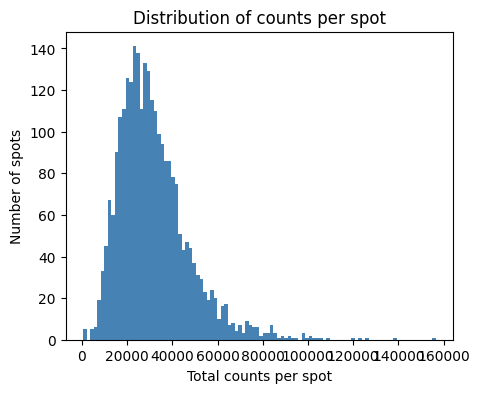

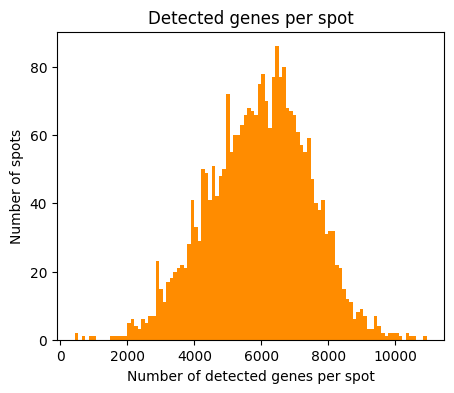

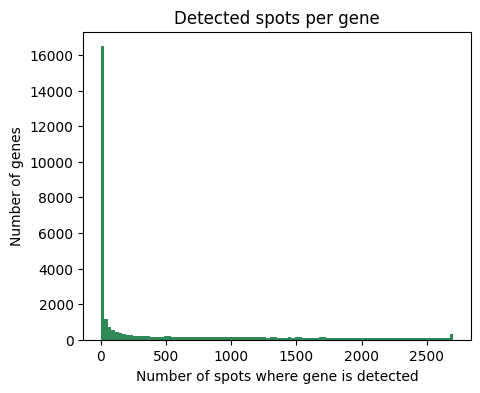

In [5]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

adata = sdata.tables[list(sdata.tables.keys())[0]]

# --- Compute QC metrics if you haven't already ---
sc.pp.calculate_qc_metrics(adata, inplace=True)

# --- Histogram: total counts per spot (cell) ---
plt.figure(figsize=(5,4))
plt.hist(adata.obs['total_counts'], bins=100, color='steelblue')
plt.xlabel('Total counts per spot')
plt.ylabel('Number of spots')
plt.title('Distribution of counts per spot')
plt.show()

# --- Histogram: number of genes detected per spot ---
plt.figure(figsize=(5,4))
plt.hist(adata.obs['n_genes_by_counts'], bins=100, color='darkorange')
plt.xlabel('Number of detected genes per spot')
plt.ylabel('Number of spots')
plt.title('Detected genes per spot')
plt.show()

# --- Histogram: number of spots per gene ---
# Sum over axis=0 gives counts per gene
counts_per_gene = np.array((adata.X > 0).sum(axis=0)).flatten()

plt.figure(figsize=(5,4))
plt.hist(counts_per_gene, bins=100, color='seagreen')
plt.xlabel('Number of spots where gene is detected')
plt.ylabel('Number of genes')
plt.title('Detected spots per gene')
plt.show()

In [6]:
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['n_genes_by_counts'] > 1000, :]
adata = adata[adata.obs['total_counts'] < 100000, :]


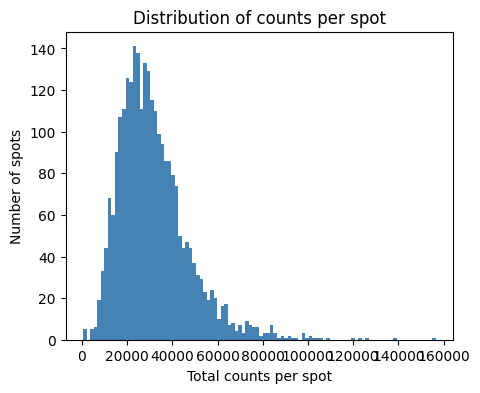

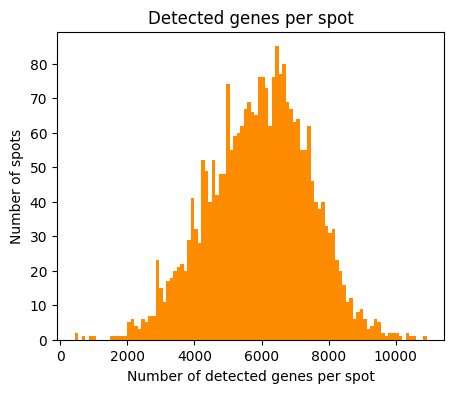

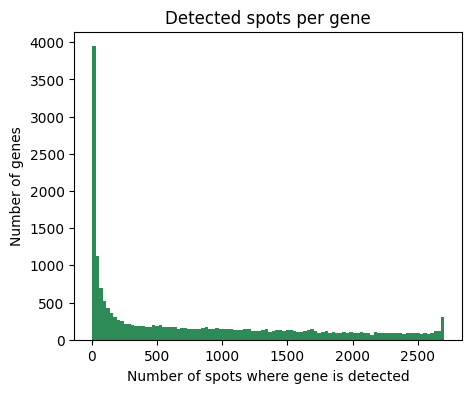

In [7]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

adata = sdata.tables[list(sdata.tables.keys())[0]]

# --- Compute QC metrics if you haven't already ---
sc.pp.calculate_qc_metrics(adata, inplace=True)

# --- Histogram: total counts per spot (cell) ---
plt.figure(figsize=(5,4))
plt.hist(adata.obs['total_counts'], bins=100, color='steelblue')
plt.xlabel('Total counts per spot')
plt.ylabel('Number of spots')
plt.title('Distribution of counts per spot')
plt.show()

# --- Histogram: number of genes detected per spot ---
plt.figure(figsize=(5,4))
plt.hist(adata.obs['n_genes_by_counts'], bins=100, color='darkorange')
plt.xlabel('Number of detected genes per spot')
plt.ylabel('Number of spots')
plt.title('Detected genes per spot')
plt.show()

# --- Histogram: number of spots per gene ---
# Sum over axis=0 gives counts per gene
counts_per_gene = np.array((adata.X > 0).sum(axis=0)).flatten()

plt.figure(figsize=(5,4))
plt.hist(counts_per_gene, bins=100, color='seagreen')
plt.xlabel('Number of spots where gene is detected')
plt.ylabel('Number of genes')
plt.title('Detected spots per gene')
plt.show()

/gpfs/commons/home/svaidyanathan/miniconda3/envs/xenium-env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/gpfs/commons/home/svaidyanathan/miniconda3/envs/xenium-env/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/gpfs/commons/home/svaidyanathan/miniconda3/envs/xenium-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


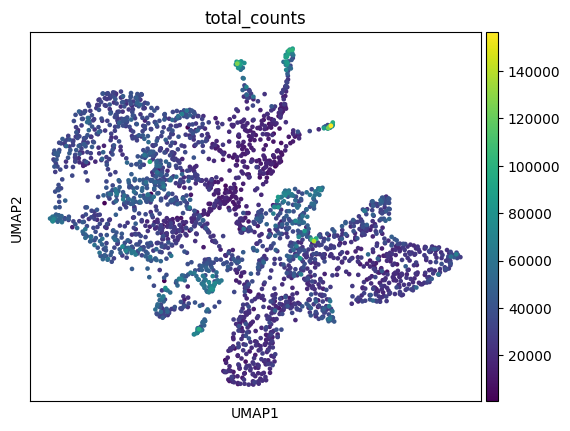

Plotting markers found in data: ['Slc17a7', 'Camk2a', 'Gad1', 'Gad2', 'Aqp4', 'Gfap', 'Plp1', 'Mbp', 'Pdgfra', 'P2ry12', 'Foxj1']


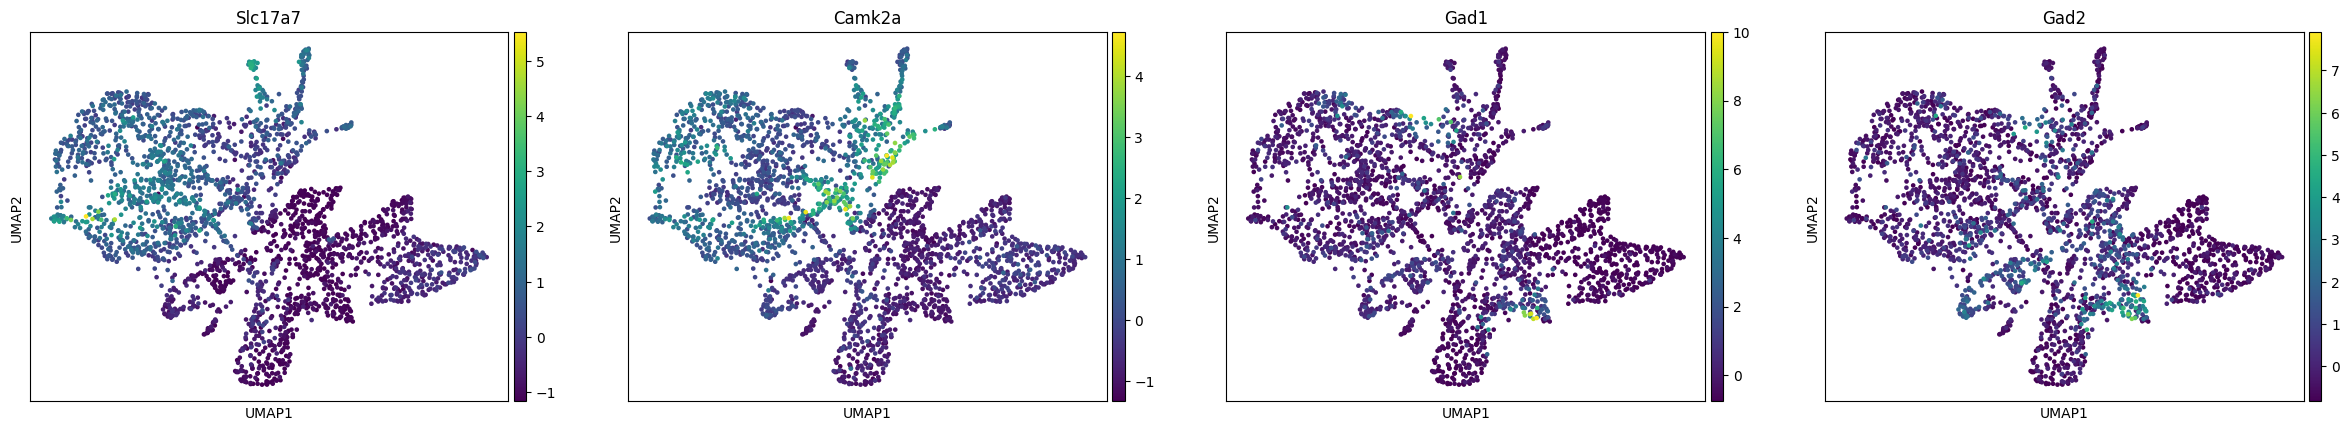

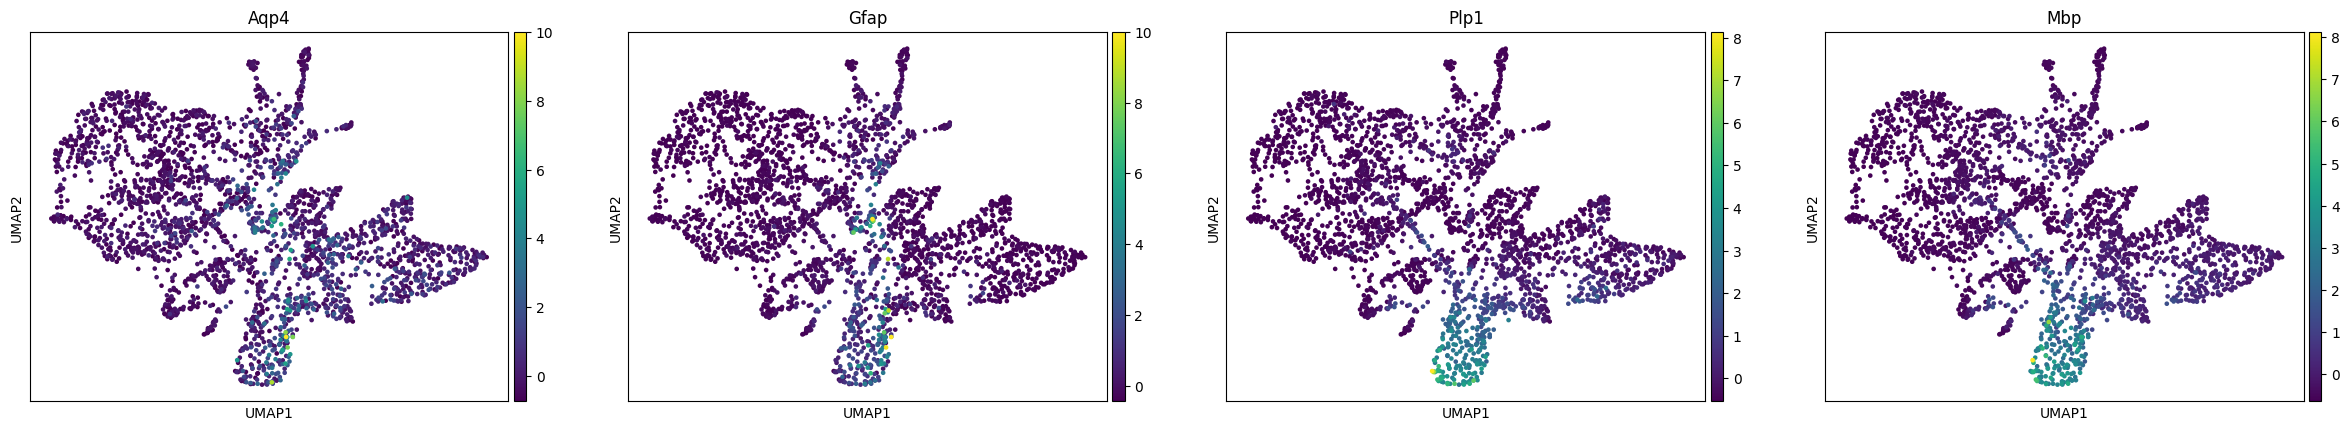

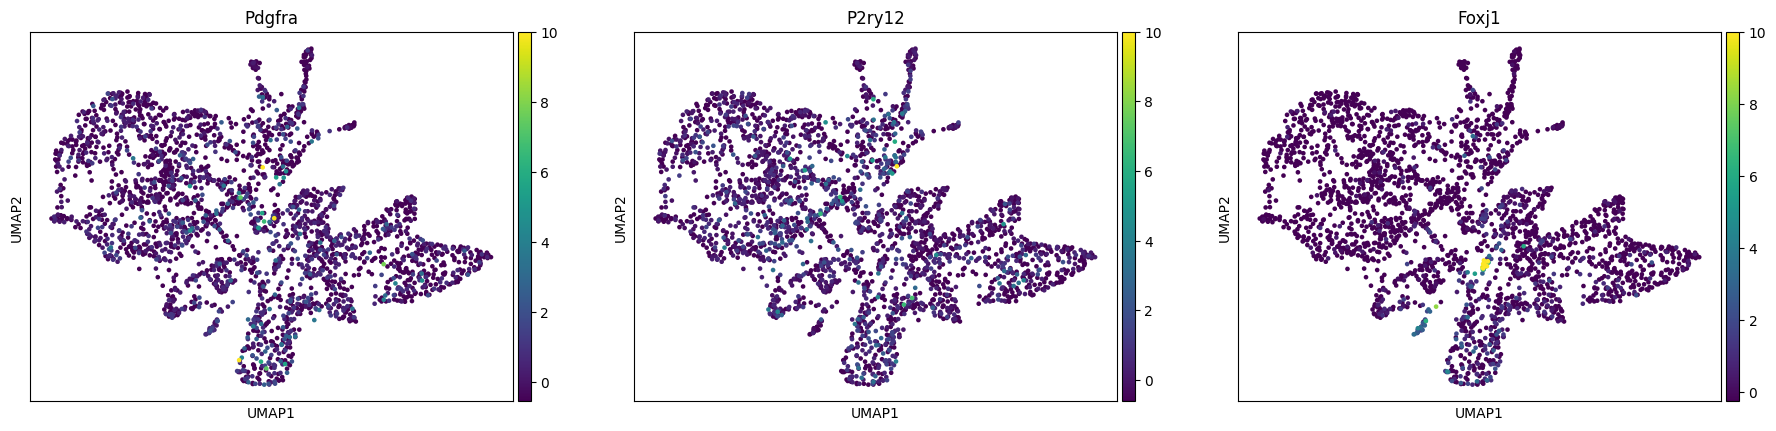

In [ ]:
import scanpy as sc
import numpy as np

# use your filtered AnnData
adata = sdata.tables[list(sdata.tables.keys())[0]]

# --- normalize + log1p ---
sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# (optional but recommended) focus on informative genes
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)
adata = adata[:, adata.var.highly_variable].copy()

# --- PCA (20 PCs) ---
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=20)

# --- UMAP ---
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.umap(adata)

# --- UMAP colored by library size ---
if "total_counts" not in adata.obs:
    sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pl.umap(adata, color="total_counts")

# --- UMAP colored by canonical mouse brain markers ---
markers = {
    "Excitatory": ["Slc17a7", "Camk2a"],
    "Inhibitory": ["Gad1", "Gad2"],
    "Astro": ["Aqp4", "Gfap"],
    "Oligo": ["Plp1", "Mbp"],
    "OPC": ["Pdgfra"],
    "Microglia": ["Cx3cr1", "P2ry12"],
    "Endothelial": ["Pecam1", "Kdr"],
    "Ependymal": ["Foxj1"],
}

# keep only genes present in this dataset
gene_list = [g for grp in markers.values() for g in grp if g in adata.var_names]
print("Plotting markers found in data:", gene_list)

# plot in small batches to keep figures readable
for chunk_start in range(0, len(gene_list), 4):
    sc.pl.umap(adata, color=gene_list[chunk_start:chunk_start+4])


In [8]:
# use your filtered AnnData
adata = sdata.tables[list(sdata.tables.keys())[0]]

# --- normalize + log1p ---
sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# (optional but recommended) focus on informative genes
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)
adata = adata[:, adata.var.highly_variable].copy()


/gpfs/commons/home/svaidyanathan/miniconda3/envs/xenium-env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


In [ ]:
import numpy as np
import scanpy as sc
import squidpy as sq

adata = sdata.tables["table"]

# image → NumPy (H, W, C)
img_key = next((k for k in sdata.images if "hires" in k), next(iter(sdata.images)))
da = sdata.images[img_key]                 # xarray DataArray
print(img_key)
img_np = da.transpose("y", "x", "c").compute().values

# store: keep original, set aligned to standard key used by squidpy
adata.obsm["spatial_orig"] = adata.obsm["spatial"].copy()
adata.obsm["spatial"] = img_np  # <-- squidpy will find this

# QC fields if missing
if "total_counts" not in adata.obs:
    sc.pp.calculate_qc_metrics(adata, inplace=True)


/gpfs/commons/home/svaidyanathan/miniconda3/envs/xenium-env/lib/python3.11/site-packages/squidpy/gr/_utils.py:23: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  CAN_USE_SPARSE_ARRAY = Version(anndata.__version__) >= Version("0.11.0rc1")
/gpfs/commons/home/svaidyanathan/miniconda3/envs/xenium-env/lib/python3.11/site-packages/anndata/__init__.py:70: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


In [ ]:

# plot: library size
sq.pl.spatial_scatter(
    adata,
    color="total_counts",
    img=img_np,
    size=1.2,
    scale_factor = 10.0,
    alpha=0.9,
    dpi=150,
)

# plot: marker panels
markers = ["Slc17a7","Camk2a","Gad1","Gad2","Plp1","Mbp","Aqp4","Gfap","Pdgfra","Cx3cr1","P2ry12","Pecam1","Kdr","Foxj1"]
present = [g for g in markers if g in adata.var_names]
for i in range(0, len(present), 4):
    sq.pl.spatial_scatter(
        adata,
        color=present[i:i+4],
        img=img_np,
        size=1000,
        alpha=0.9,
        dpi=150,
    )



ValueError: Can't make a list from variable: `10`